# PAX-Ray++ Visualizer and Model

# Import kagglehub

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("constantinseibold/anatomy-in-chest-x-rays-pax-ray")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/constantinseibold/anatomy-in-chest-x-rays-pax-ray/versions/1


In [2]:
!ls -lh $path

total 992M
drwxr-xr-x 3 root root 4.0K Dec 24 16:32 images_patlas
-rw-r--r-- 1 root root  99M Dec 24 16:32 paxray_test.json
-rw-r--r-- 1 root root 893M Dec 24 16:33 paxray_train_val.json


## Import Dependencies

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw
import json
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder


2024-12-24 17:49:11.596380: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-24 17:49:11.772141: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-24 17:49:11.890300: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-24 17:49:11.890990: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-24 17:49:12.062868: I tensorflow/core/platform/cpu_feature_gua

## Load data

In [4]:
paxray_train_val_path = f"{path}/paxray_train_val.json"

# Load the JSON data
with open(paxray_train_val_path, 'r') as file:
	data = json.load(file)

data_images = data['images']
data_categories = data['categories']
data_annotations = data['annotations']

## Convert data to Dataframes

In [5]:
df_annotations = pd.DataFrame(data_annotations)
df_annotations.head()

,id,image_id,category_id,segmentation,area,bbox,iscrowd
0,178,1,0,"{'size': [512, 512], 'counts': 'kTV3:R;J[H4XM<...",37094,"[204.0, 0.0, 121.0, 512.0]",0
1,179,1,1,"{'size': [512, 512], 'counts': 'YPX3<d?2N2J6N0...",3449,"[208.0, 0.0, 96.0, 58.0]",0
2,180,1,2,"{'size': [512, 512], 'counts': 'kTV3:R;J[H4XM<...",33259,"[204.0, 0.0, 103.0, 488.0]",0
3,181,1,3,"{'size': [512, 512], 'counts': 'Xo[36f?6N0L400...",5664,"[215.0, 430.0, 110.0, 82.0]",0
4,186,1,8,"{'size': [512, 512], 'counts': 'P`c33m?4L2N2N2...",563,"[231.0, 0.0, 49.0, 17.0]",0


In [6]:
df_categories = pd.DataFrame(data_categories)
df_categories.head()

,supercategory,id,name
0,spine,0,spine
1,cervical spine,1,cervical spine
2,thoracic spine,2,thoracic spine
3,lumbar spine,3,lumbar spine
4,vertebrae C1,4,vertebrae C1


In [7]:
df_images = pd.DataFrame(data_images)
df_images.head()

,id,file_name,height,width,date_captured
0,1,0215a_frontal.png,512,512,
1,3,COVID1910_0015_lateral.png,512,512,
2,4,RibFrac_122_frontal.png,512,512,
3,5,RSNAPE_7f63908e9197_7c55069657e7_frontal.png,512,512,
4,6,RSNAPE_7b0c19ab794c_f96b92eced83_frontal.png,512,512,


## Merge Dataframes

In [8]:
df_merged = pd.merge(df_annotations, df_categories, left_on='category_id', right_on='id')
df_merged = pd.merge(df_merged, df_images, left_on='image_id', right_on='id')

# Visualizer

In [9]:
def visualizer(row):
    # Extract the row information
    print(row)
    bbox = row['bbox']
    file_name = row['file_name']

    # Load the image
    image_path = f"{path}/images_patlas/images_patlas/{file_name}"
    image = Image.open(image_path)
    # Draw the bounding box on the image
    draw = ImageDraw.Draw(image)
    x, y, width, height = bbox
    draw.rectangle([x, y, x + width, y + height], outline="red", width=2)

    # Display the image
    image.show()

id_x                                                           196
image_id                                                         1
category_id                                                     18
segmentation     {'size': [512, 512], 'counts': 'aWY38f?4N2N0N4...
area                                                          3675
bbox                                   [210.0, 218.0, 84.0, 111.0]
iscrowd                                                          0
supercategory                                         vertebrae T8
id_y                                                            18
name                                                  vertebrae T8
id                                                               1
file_name                                        0215a_frontal.png
height                                                         512
width                                                          512
date_captured                                                 

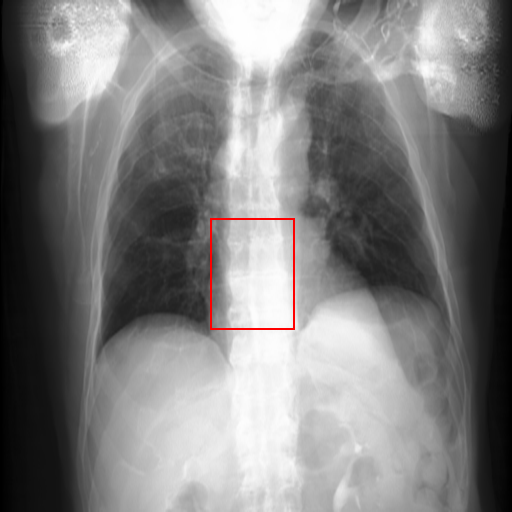

In [10]:
visualizer(df_merged.iloc[14])

# Model

## Normalizing variables

In [11]:
# Encode the supercategory values
encoder = LabelEncoder()
df_merged['supercategory_label'] = encoder.fit_transform(df_merged['supercategory'])

In [12]:
# For the sake of this example, we will only use a subset of the data
train_data = df_merged.sample(frac=0.05, random_state=32)

## Preparing Data

In [13]:
# Prepare the data
# Assuming df_merged contains the necessary columns: 'file_name', 'bbox', 'supercategory_label'
scaler = MinMaxScaler()

train_data['bbox_minmax'] = train_data['bbox'].apply(lambda x: scaler.fit_transform(np.reshape(x, [-1, 1])).flatten())
X_images = train_data['file_name'].values
X_bboxes = np.array(train_data['bbox_minmax'].tolist())
y_labels = train_data['supercategory_label'].values

## Train Val Splitting

In [14]:
# Split the data into training and testing sets
X_images_train, X_images_val, X_bboxes_train, X_bboxes_val, y_train, y_val = train_test_split(
    X_images, X_bboxes, y_labels, test_size=0.2, random_state=42)

## Image Generator

In [15]:
# Image data generator
datagen = ImageDataGenerator(rescale=1./255)

def image_generator(file_names, bboxes, labels, batch_size=32):
    while True:
        for start in range(0, len(file_names), batch_size):
            end = min(start + batch_size, len(file_names))
            batch_file_names = file_names[start:end]
            batch_bboxes = bboxes[start:end]
            batch_labels = labels[start:end]
            
            images = []
            for file_name in batch_file_names:
                img_path = f"{path}/images_patlas/images_patlas/{file_name}"
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
                img = tf.keras.preprocessing.image.img_to_array(img)
                images.append(img)
            
            yield (tf.convert_to_tensor(np.array(images)), tf.convert_to_tensor(np.array(batch_bboxes))), tf.convert_to_tensor(np.array(batch_labels))

## Model

In [16]:
# Define the model
image_input = Input(shape=(128, 128, 3), name='image_input')
bbox_input = Input(shape=(4,), name='bbox_input')

x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)

x = Concatenate()([x, bbox_input])
x = Dense(128, activation='relu')(x)
output = Dense(len(np.unique(y_labels)), activation='softmax')(x)

model = Model(inputs=[image_input, bbox_input], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Train the model
batch_size = 32
train_generator = image_generator(X_images_train, X_bboxes_train, y_train, batch_size=batch_size)
test_generator = image_generator(X_images_val, X_bboxes_val, y_val, batch_size=batch_size)

steps_per_epoch = len(X_images_train) // batch_size
validation_steps = len(X_images_val) // batch_size

model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, validation_data=test_generator, validation_steps=validation_steps)

2024-12-24 17:50:15.865637: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-24 17:50:18.026981: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-24 17:50:18.027047: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-24 17:50:18.034234: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-24 17:50:18.034302: I external/local_xla/xla/stream_executor

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 14,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 25088)     │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_input          │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 25092)     │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ bbox_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  3,211,904 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 177)       │     22,833 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,327,985 (12.70 MB)

 Trainable params: 3,327,985 (12.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['image_input', 'bbox_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(
I0000 00:00:1735073422.510047    9200 service.cc:145] XLA service 0x7fd1e8003260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735073422.510110    9200 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-12-24 17:50:22.618665: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-24 17:50:22.961925: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8900


   2/2031 ━━━━━━━━━━━━━━━━━━━━ 28s 14ms/step - accuracy: 0.0000e+00 - loss: 104.9991 

I0000 00:00:1735073429.958732    9200 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2031/2031 ━━━━━━━━━━━━━━━━━━━━ 723s 352ms/step - accuracy: 0.0515 - loss: 6.5960 - val_accuracy: 0.1787 - val_loss: 3.0716
Epoch 2/10
   2/2031 ━━━━━━━━━━━━━━━━━━━━ 45s 22ms/step - accuracy: 0.1612 - loss: 3.0196  

I0000 00:00:1735074149.649508    9201 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_2', 68 bytes spill stores, 68 bytes spill loads



2031/2031 ━━━━━━━━━━━━━━━━━━━━ 627s 306ms/step - accuracy: 0.1911 - loss: 2.9681 - val_accuracy: 0.2233 - val_loss: 2.7725
Epoch 3/10
2031/2031 ━━━━━━━━━━━━━━━━━━━━ 595s 293ms/step - accuracy: 0.2252 - loss: 2.7197 - val_accuracy: 0.2457 - val_loss: 2.6551
Epoch 4/10
2031/2031 ━━━━━━━━━━━━━━━━━━━━ 622s 307ms/step - accuracy: 0.2467 - loss: 2.5941 - val_accuracy: 0.2585 - val_loss: 2.5716
Epoch 5/10
2031/2031 ━━━━━━━━━━━━━━━━━━━━ 563s 277ms/step - accuracy: 0.2661 - loss: 2.5020 - val_accuracy: 0.2659 - val_loss: 2.5409
Epoch 6/10
2031/2031 ━━━━━━━━━━━━━━━━━━━━ 575s 283ms/step - accuracy: 0.2860 - loss: 2.4286 - val_accuracy: 0.2682 - val_loss: 2.5321
Epoch 7/10
2031/2031 ━━━━━━━━━━━━━━━━━━━━ 611s 301ms/step - accuracy: 0.3038 - loss: 2.3577 - val_accuracy: 0.2661 - val_loss: 2.5449
Epoch 8/10
2031/2031 ━━━━━━━━━━━━━━━━━━━━ 577s 284ms/step - accuracy: 0.3250 - loss: 2.2906 - val_accuracy: 0.2635 - val_loss: 2.5777
Epoch 9/10
2031/2031 ━━━━━━━━━━━━━━━━━━━━ 609s 300ms/step - accuracy: 0.3

# Predictions

In [17]:
paxray_test_path = f"{path}/paxray_test.json"

# Load the JSON data
with open(paxray_test_path, 'r') as file:
	test_data = json.load(file)

test_data_images = data['images']
test_data_categories = data['categories']
test_data_annotations = data['annotations']
test_df_annotations = pd.DataFrame(test_data_annotations)
test_df_categories = pd.DataFrame(test_data_categories)
test_df_images = pd.DataFrame(test_data_images)
test_df_merged = pd.merge(test_df_annotations, test_df_categories, left_on='category_id', right_on='id')
test_df_merged = pd.merge(test_df_merged, test_df_images, left_on='image_id', right_on='id')


In [18]:
test_data = test_df_merged.iloc[0]

In [19]:
def predict(test_data):
    y_predict = []
    print()
    test_data['bbox_minmax'] = scaler.fit_transform(np.reshape(test_data['bbox'], [-1, 1])).flatten()
    X_images_final_test = test_data['file_name']
    X_bboxes_final_test = np.array(test_data['bbox_minmax'].tolist())
    images = []
    img_path = f"{path}/images_patlas/images_patlas/{test_data['file_name']}"
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
    img = tf.keras.preprocessing.image.img_to_array(img)
    images.append(img)
    pred = model.predict([tf.convert_to_tensor(np.array(images)), tf.convert_to_tensor(np.array([X_bboxes_final_test]))])
    res = np.argmax(pred)
    y_predict.append(encoder.inverse_transform([res]))
    
    return y_predict